## 使用卷积神经网络的深度计算机视觉

### 视觉皮层的架构

### 卷积层

In [1]:
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

### 池化层

In [2]:
import tensorflow as tf
from tensorflow import keras

max_pool = keras.layers.MaxPool2D(pool_size=2)
output = tf.nn.max_pool(images, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID")
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))

### CNN架构

In [3]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding="same", input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

### 使用Keras实现ResNet-34CNN

In [4]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="SAME", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

### 使用Keras的预训练模型

In [6]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')
images_resized = tf.image.resize(images, [224, 224])
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [7]:
Y_proba= model.predict(inputs)
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
 n02825657 - bell_cote    82.35%
 n03877845 - palace       6.75%
 n03781244 - monastery    4.19%

Image #1
 n03530642 - honeycomb    49.83%
 n13040303 - stinkhorn    33.96%
 n02206856 - bee          4.35%



### 迁移学习的预训练模型

In [12]:
import tensorflow_datasets as tfds
import os

os.environ['TFDS_HTTPS_PROXY'] = 'http://127.0.0.1:7890'
os.environ['TFDS_HTTP_PROXY'] = 'http://127.0.0.1:7890'
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

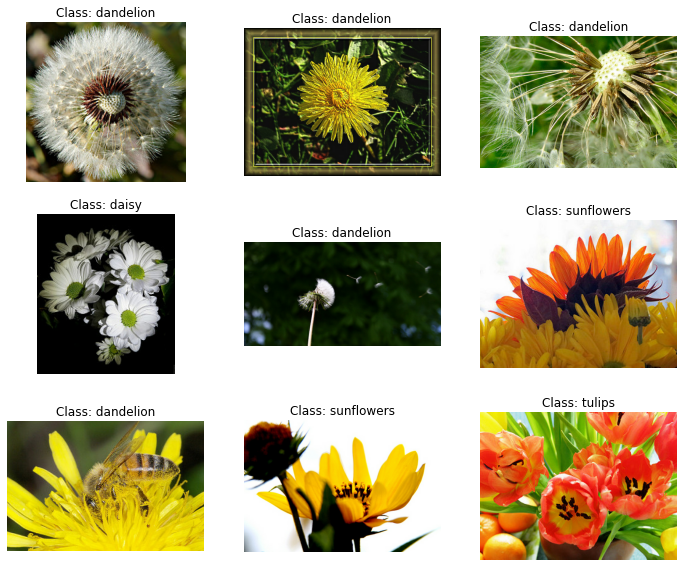

In [33]:
import matplotlib.pyplot as plt

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [34]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [36]:
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

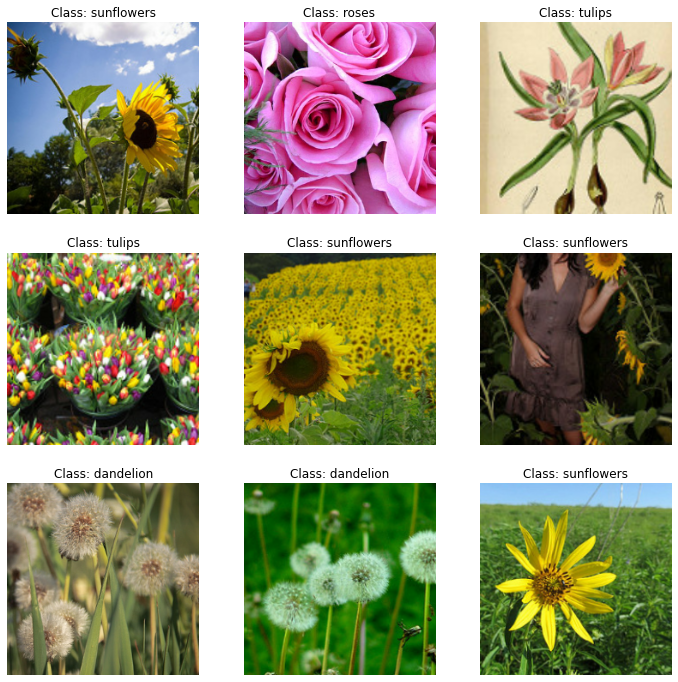

In [37]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

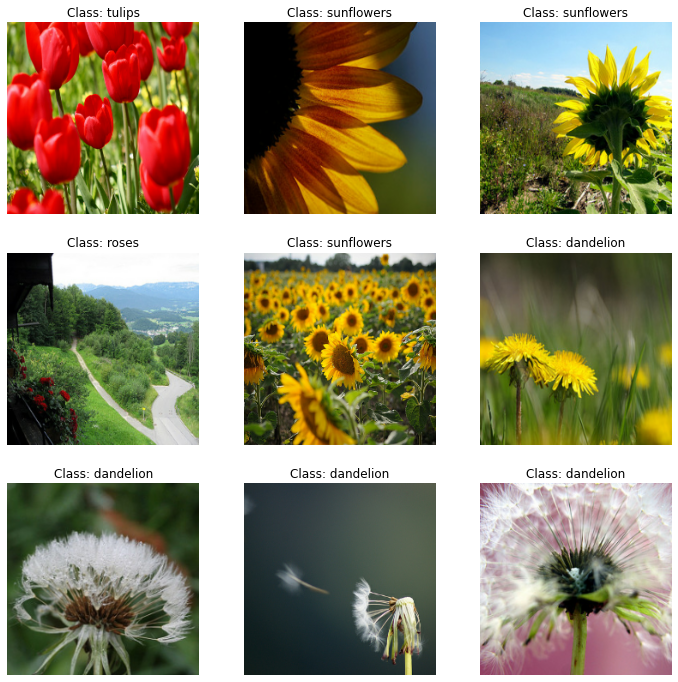

In [38]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [39]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [40]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/5
63/86 [====================>.........] - ETA: 5:56 - loss: 1.3721 - accuracy: 0.7758

KeyboardInterrupt: 

### 分类和定位

In [ ]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)

model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"], loss_weight=[0.8, 0.2], optimizer=optimizer, metrics=['accuracy'])